In [227]:
#####################
# Dependency import #
#####################

import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model as linear_model
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import sklearn.metrics as metrics
import json

In [228]:
###################
# Dataset loading #
###################

dt = pd.read_csv('city_temperature.csv')
dt.head(100)

C:\Users\teodo\AppData\Local\Temp\ipykernel_5476\3705457785.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dt = pd.read_csv('city_temperature.csv')


,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...,...,...
95,Africa,Algeria,NaN,Algiers,4,6,1995,59.0
96,Africa,Algeria,NaN,Algiers,4,7,1995,54.9
97,Africa,Algeria,NaN,Algiers,4,8,1995,54.2
98,Africa,Algeria,NaN,Algiers,4,9,1995,57.8


In [229]:
#################
# Data cleaning #
#################

dt.drop(columns=["State", "Region"], axis=1, inplace=True)
dt.drop(index=dt.loc[dt["Day"] <= 0].index, inplace=True)
dt.drop(index=dt.loc[dt["AvgTemperature"] <= -20].index, inplace=True)
dt.dropna()

dt

,Country,City,Month,Day,Year,AvgTemperature
0,Algeria,Algiers,1,1,1995,64.2
1,Algeria,Algiers,1,2,1995,49.4
2,Algeria,Algiers,1,3,1995,48.8
3,Algeria,Algiers,1,4,1995,46.4
4,Algeria,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...
2906322,US,San Juan Puerto Rico,7,27,2013,82.4
2906323,US,San Juan Puerto Rico,7,28,2013,81.6
2906324,US,San Juan Puerto Rico,7,29,2013,84.2
2906325,US,San Juan Puerto Rico,7,30,2013,83.8


<Axes: xlabel='Year', ylabel='AvgTemperature'>

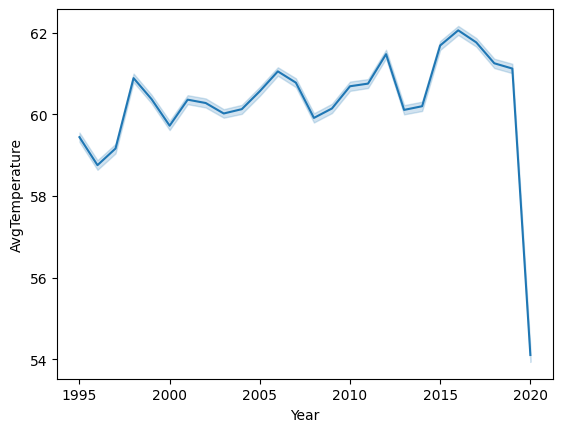

In [230]:
#######################################
# Visualisation of global temperature #
#######################################
sb.lineplot(data=dt, x="Year", y="AvgTemperature")

In [231]:

g_mse_comp = {"Training MSE" : [], "Test MSE": []}
g_mse_comp_indexes = []
g_mse_comp_c_i = 1

g_r2_progression = {"Polynomial degree" : [], "R2": []}
g_mse_progression = {"Polynomial degree" : [], "MSE": []}

tmp = dt.groupby(by=["Day", "Month", "Year"])["AvgTemperature"].mean().reset_index()

mse = None
r2 = None

degree = 1
global_model = None

def addMetrics(t_mse, c_mse, c_r2, d_i):
    global g_mse_comp_c_i
    g_mse_comp["Training MSE"].append(t_mse)
    g_mse_comp["Test MSE"].append(c_mse)
    g_mse_comp_indexes.append(g_mse_comp_c_i)
    g_mse_comp_c_i += 1
    
    g_r2_progression["Polynomial degree"].append(d_i)
    g_r2_progression["R2"].append(c_r2)
    
    g_mse_progression["Polynomial degree"].append(d_i)
    g_mse_progression["MSE"].append(c_mse)

for i in range(1, 100):
    poly_features = preprocessing.PolynomialFeatures(degree=i, include_bias=False).fit_transform(X=tmp[["Day", "Month", "Year"]])
    x_train, x_test, y_train, y_test = model_selection.train_test_split(poly_features, tmp["AvgTemperature"], train_size=0.7, test_size=0.3)
    
    _model = linear_model.LinearRegression()
    poly_regression = _model.fit(x_train, y_train)

    predictions = poly_regression.predict(x_test)
    
    t_predictions = poly_regression.predict(x_train)
    
    t_mse = metrics.mean_squared_error(y_pred=t_predictions, y_true=y_train)
    c_mse = metrics.mean_squared_error(y_pred=predictions, y_true=y_test)
    c_r2 = metrics.r2_score(y_pred=predictions, y_true=y_test)

    print("\n\n")
    print("Training MSE:", t_mse)
    print("MSE:", c_mse)
    print("R2:", c_r2)
    
    if mse is None and r2 is None:
        addMetrics(t_mse, c_mse, c_r2, i)
        mse = c_mse
        r2 = c_r2 
    else:
        if c_mse < mse:
            print("Degree: ", i)
            global_model = _model
            degree = i
            addMetrics(t_mse, c_mse, c_r2, i)
        elif c_r2 > r2:
            print("Degree: ", i)
            global_model = _model
            degree = i
            addMetrics(t_mse, c_mse, c_r2)
        else:
            break
    mse = c_mse
    r2 = c_r2
        
        
global_temp_model = {"x_intercept": global_model.intercept_, "Beta_Coefficients":  global_model.coef_.tolist(), "polynomial_degree": degree}
model_file = open(file="global_temp_model.json", mode="w")
jf = json.dump(obj=global_temp_model,fp= model_file, indent=4)
model_file.flush()
model_file.close()
del(model_file)


g_comp = pd.DataFrame(data=g_mse_comp, index=g_mse_comp_indexes)
g_r2_prog = pd.DataFrame(data=g_r2_progression, index=g_mse_comp_indexes)
g_mse_prog = pd.DataFrame(data=g_mse_progression, index=g_mse_comp_indexes)

g_comp




Training MSE: 121.5621496705282
MSE: 122.46552178556284
R2: 0.053904206881073335



Training MSE: 16.80185178786976
MSE: 16.898767899710265
R2: 0.8697716961793784
Degree:  2



Training MSE: 11.76102949428515
MSE: 11.167328953318023
R2: 0.9115523555030107
Degree:  3



Training MSE: 5.895723674559122
MSE: 6.23533765707124
R2: 0.9522949591240922
Degree:  4



Training MSE: 5.743684810946743
MSE: 5.633117481456719
R2: 0.9565975708981808
Degree:  5



Training MSE: 11.497984121314577
MSE: 12.09618959547283
R2: 0.9049046610404671


,Training MSE,Test MSE
1,121.562150,122.465522
2,16.801852,16.898768
3,11.761029,11.167329
4,5.895724,6.235338
5,5.743685,5.633117


Text(0.5, 0, 'Iteration')

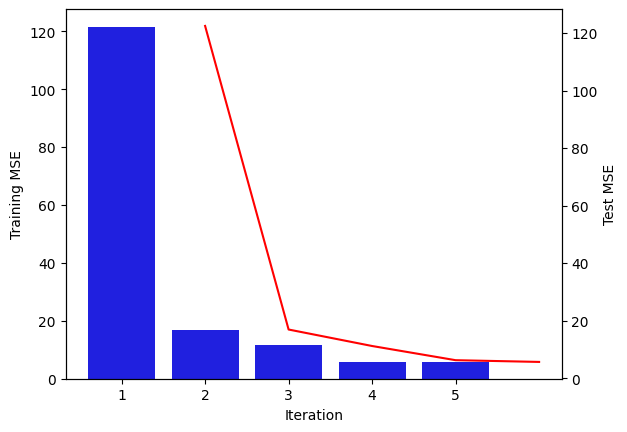

In [232]:
##########################################################################################
# Comparison of the MSE in predicting training data VS testing data for the Global model #
##########################################################################################
p1 = sb.barplot(data=g_comp, x=g_comp.index, y="Training MSE", color="b")
p1.set_xlabel("Iteration")
plt.twinx()
p2 = sb.lineplot(data=g_comp, x=g_comp.index, y="Test MSE",color="r")
p2.set_xlabel("Iteration")

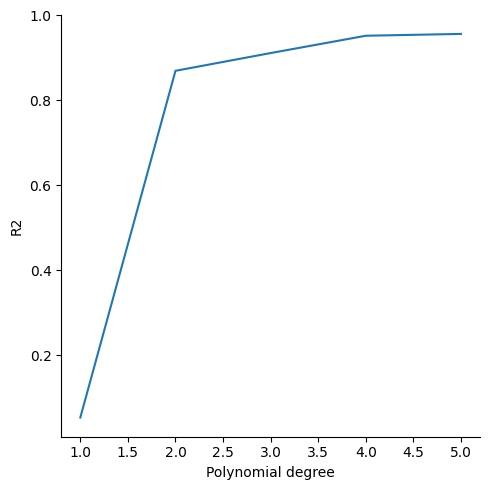

In [233]:
#########################################################################################################
# Visualisation of the R2 score progression in relation with the polynomial degree for the Global model #
#########################################################################################################

sb.relplot(data= g_r2_prog, x="Polynomial degree", y="R2", kind="line")

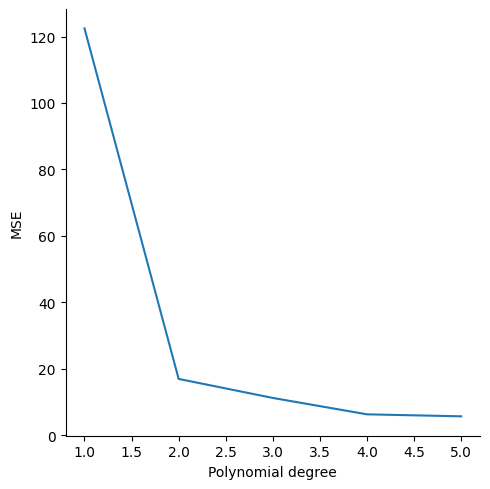

In [234]:
##########################################################################################################
# Visualisation of the MSE score progression in relation with the polynomial degree for the Global model #
##########################################################################################################

sb.relplot(data= g_mse_prog, x="Polynomial degree", y="MSE", kind="line")

<Axes: xlabel='Year', ylabel='AvgTemperature'>

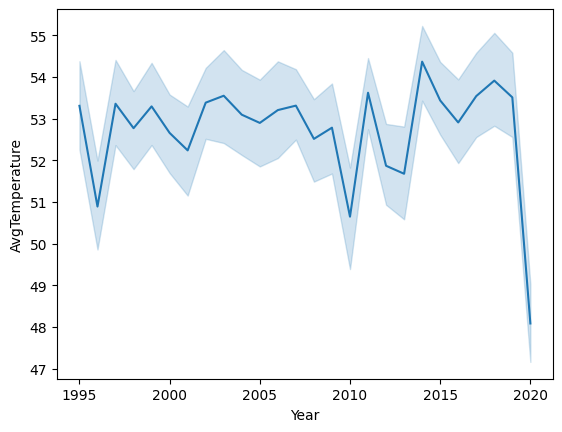

In [235]:
#########################################
# Visualisation of London's temperature #
#########################################

dtl =  dt[(dt['Country'] == 'United Kingdom') & (dt['City'] == 'London')]
sb.lineplot(data=dtl, x="Year", y="AvgTemperature")

In [236]:

l_mse_comp = {"Training MSE" : [], "Test MSE": []}
l_mse_comp_indexes = []
l_mse_comp_c_i = 1

l_r2_progression = {"Polynomial degree" : [], "R2": []}
l_mse_progression = {"Polynomial degree" : [], "MSE": []}


mse = None
r2 = None

l_degree = 1
l_model = None

def addMetrics(t_mse, c_mse, c_r2, d_i):
    global l_mse_comp_c_i
    l_mse_comp["Training MSE"].append(t_mse)
    l_mse_comp["Test MSE"].append(c_mse)
    l_mse_comp_indexes.append(l_mse_comp_c_i)
    l_mse_comp_c_i += 1
    
    l_r2_progression["Polynomial degree"].append(d_i)
    l_r2_progression["R2"].append(c_r2)
    
    l_mse_progression["Polynomial degree"].append(d_i)
    l_mse_progression["MSE"].append(c_mse)

for i in range(1, 100):
    poly_features = preprocessing.PolynomialFeatures(degree=i, include_bias=False).fit_transform(X=dtl[["Day", "Month", "Year"]])
    x_train, x_test, y_train, y_test = model_selection.train_test_split(poly_features, dtl["AvgTemperature"], train_size=0.7, test_size=0.3)
    
    _model = linear_model.LinearRegression()
    poly_regression = _model.fit(x_train, y_train)

    predictions = poly_regression.predict(x_test)
    
    t_predictions = poly_regression.predict(x_train)
    
    t_mse = metrics.mean_squared_error(y_pred=t_predictions, y_true=y_train)
    c_mse = metrics.mean_squared_error(y_pred=predictions, y_true=y_test)
    c_r2 = metrics.r2_score(y_pred=predictions, y_true=y_test)

    print("\n\n")
    print("Training MSE:", t_mse)
    print("MSE:", c_mse)
    print("R2:", c_r2)
    
    if mse is None and r2 is None:
        addMetrics(t_mse, c_mse, c_r2, i)
        mse = c_mse
        r2 = c_r2 
    else:
        if c_mse < mse:
            print("Degree: ", i)
            l_model = _model
            l_degree = i
            addMetrics(t_mse, c_mse, c_r2, i)
        elif c_r2 > r2:
            print("Degree: ", i)
            l_model = _model
            l_degree = i
            addMetrics(t_mse, c_mse, c_r2)
        else:
            break
    mse = c_mse
    r2 = c_r2
        
        
london_temp_model = {"x_intercept": l_model.intercept_, "Beta_Coefficients":  l_model.coef_.tolist(), "polynomial_degree": l_degree}
model_file = open(file="london_temp_model.json", mode="w")
jf = json.dump(obj=london_temp_model,fp= model_file, indent=4)
model_file.flush()
model_file.close()
del(model_file)


l_comp = pd.DataFrame(data=l_mse_comp, index=l_mse_comp_indexes)
l_r2_prog = pd.DataFrame(data=l_r2_progression, index=l_mse_comp_indexes)
l_mse_prog = pd.DataFrame(data=l_mse_progression, index=l_mse_comp_indexes)

l_comp




Training MSE: 94.91235038607161
MSE: 93.70390167568904
R2: 0.05092755546273886



Training MSE: 38.363593137085445
MSE: 39.27901147011825
R2: 0.615029031431791
Degree:  2



Training MSE: 31.927607764771146
MSE: 33.056649131828074
R2: 0.66810722515969
Degree:  3



Training MSE: 26.429788542131824
MSE: 27.972825425161286
R2: 0.7207526402560392
Degree:  4



Training MSE: 25.95900338586485
MSE: 26.20844845253653
R2: 0.7365108315337379
Degree:  5



Training MSE: 26.296190525322505
MSE: 25.94681181626108
R2: 0.7397709094699552
Degree:  6



Training MSE: 26.3358032852251
MSE: 26.725736046344824
R2: 0.7279249226456328


,Training MSE,Test MSE
1,94.912350,93.703902
2,38.363593,39.279011
3,31.927608,33.056649
4,26.429789,27.972825
5,25.959003,26.208448
6,26.296191,25.946812


Text(0.5, 0, 'Iteration')

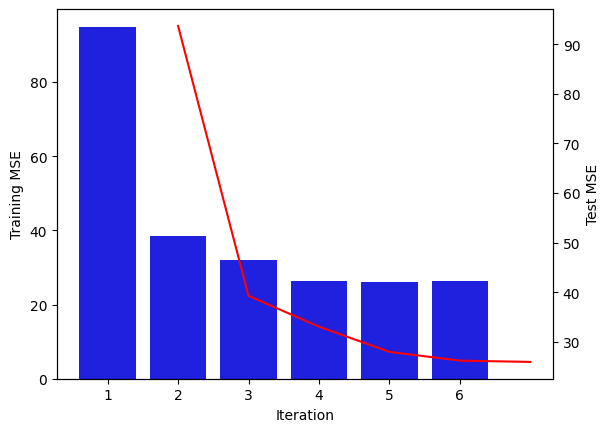

In [237]:
##########################################################################################
# Comparison of the MSE in predicting training data VS testing data for the Global model #
##########################################################################################
p1 = sb.barplot(data=l_comp, x=l_comp.index, y="Training MSE", color="b")
p1.set_xlabel("Iteration")
plt.twinx()
p2 = sb.lineplot(data=l_comp, x=l_comp.index, y="Test MSE",color="r")
p2.set_xlabel("Iteration")

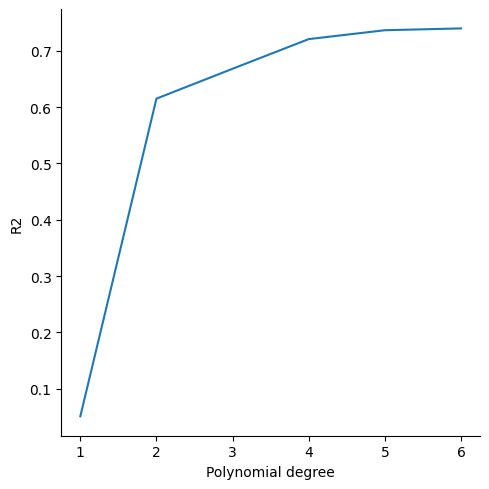

In [238]:
#########################################################################################################
# Visualisation of the R2 score progression in relation with the polynomial degree for the Global model #
#########################################################################################################

sb.relplot(data= l_r2_prog, x="Polynomial degree", y="R2", kind="line")

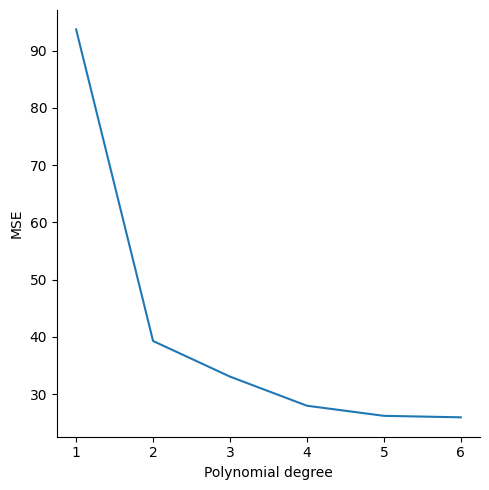

In [239]:
##########################################################################################################
# Visualisation of the MSE score progression in relation with the polynomial degree for the Global model #
##########################################################################################################

sb.relplot(data= l_mse_prog, x="Polynomial degree", y="MSE", kind="line")